<a href="https://colab.research.google.com/github/lukigu/real-estate-prediction/blob/main/xgboost_gliwice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import json
import datetime
import math
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)
pd.options.mode.chained_assignment = None

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics

from google.colab import files
#uploaded = files.upload()

In [2]:
fed_files = ['Gliwice1.csv']

dfs = [pd.read_csv(f, parse_dates=True, index_col=0) for f in fed_files]

In [3]:
price_data = dfs[0]

In [4]:
price_data["adj_cena"] = price_data["srednia cena"] / price_data["inflacja"] * 100

In [5]:
price_data["nastepny_kwartal"] = price_data["adj_cena"].shift(-3)

In [6]:
price_data

,pkb,inflacja,liczba sprzedanych lokali,srednie zarobki w wojewodztwie,liczba studentow na 10tys,srednia cena,adj_cena,nastepny_kwartal
rok,,,,,,,,
2010 Q1,331407.0,102.9,201,3648.67,391,190574,185203.109815,201627.184466
2010 Q2,350786.0,102.2,236,3446.68,391,191074,186960.861057,182342.256214
2010 Q3,358179.7,102.3,227,3524.17,391,193899,189539.589443,181420.749280
2010 Q4,406470.8,103.0,199,3913.18,391,207676,201627.184466,178432.122371
2011 Q1,358866.8,104.6,160,3799.45,368,190730,182342.256214,196793.834297
2011 Q2,378064.9,104.1,216,3719.88,368,188859,181420.749280,194446.064140
2011 Q3,387151.9,104.6,231,3775.52,368,186640,178432.122371,169579.403272
2011 Q4,441167.7,103.8,234,4048.62,368,204272,196793.834297,158609.615385
2012 Q1,377803.3,102.9,189,4003.08,344,200085,194446.064140,170577.329491


In [7]:
price_data.dropna(inplace=True)

In [8]:
price_data["change"] = (price_data["nastepny_kwartal"] > price_data["adj_cena"]).astype(int)

In [9]:
predictors = [ 'pkb', 'liczba studentow na 10tys','liczba sprzedanych lokali',
       'srednie zarobki w wojewodztwie', 'adj_cena']
target = "change"

In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.metrics import accuracy_score
import numpy as np

START =  20 #take 5 y and 2 q of data
STEP = 4 #predict for 4q 1 year

params = {
    'objective': 'binary:logistic',  # Specify the objective as binary classification
    'n_estimators': 100,  # Number of trees in the ensemble
    'learning_rate': 0.1,  # Learning rate for boosting
    'max_depth': 3,  # Maximum tree depth
    'subsample': 0.8,  # Subsample ratio of the training instances
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'random_state': 1  # Random state for reproducibility
}

def predict(train, test, predictors, target):
    model = xgb.XGBClassifier(**params)
    model.fit(train[predictors], train[target])
    preds = model.predict(test[predictors])
    return preds

def backtest(data, predictors, target):
    all_preds = []
    for i in range(START, data.shape[0], STEP):
        train = price_data.iloc[:i]
        test = price_data.iloc[i:(i+STEP)]
        all_preds.append(predict(train, test, predictors, target))

    preds = np.concatenate(all_preds)
    return preds, accuracy_score(data.iloc[START:][target], preds)

In [11]:
preds, accuracy = backtest(price_data, predictors, target)

In [12]:
preds

array([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

In [13]:
accuracy

0.84

In [14]:
pred_match = (preds == price_data[target].iloc[START:])
pred_match[pred_match == True] = "green"
pred_match[pred_match == False] = "red"

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [Text(0, 0, '2015 Q1'),
  Text(1, 0, '2015 Q2'),
  Text(2, 0, '2015 Q3'),
  Text(3, 0, '2015 Q4'),
  Text(4, 0, '2016 Q1'),
  Text(5, 0, '2016 Q2'),
  Text(6, 0, '2016 Q3'),
  Text(7, 0, '2016 Q4'),
  Text(8, 0, '2017 Q1'),
  Text(9, 0, '2017 Q2'),
  Text(10, 0, '2017 Q3'),
  Text(11, 0, '2017 Q4'),
  Text(12, 0, '2018 Q1'),
  Text(13, 0, '2018 Q2'),
  Text(14, 0, '2018 Q3'),
  Text(15, 0, '2018 Q4'),
  Text(16, 0, '2019 Q1'),
  Text(17, 0, '2019 Q2'),
  Text(18, 0, '2019 Q3'),
  Text(19, 0, '2019 Q4'),
  Text(20, 0, '2020 Q1'),
  Text(21, 0, '2020 Q2'),
  Text(22, 0, '2020 Q3'),
  Text(23, 0, '2020 Q4'),
  Text(24, 0, '2021 Q1')])

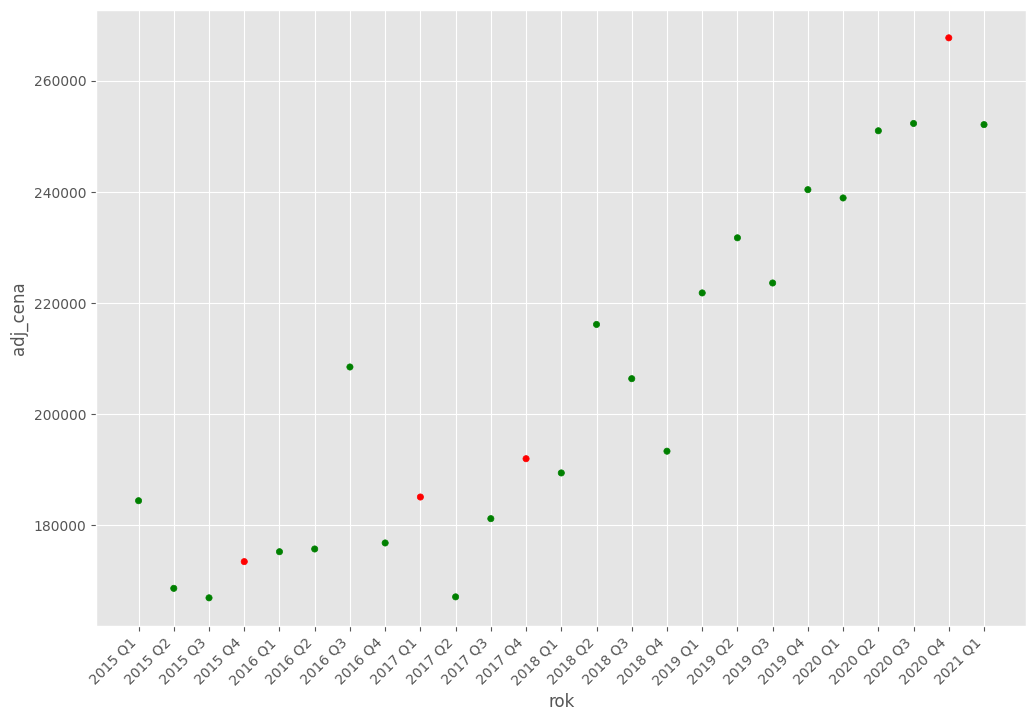

In [15]:
import matplotlib.pyplot as plt
plot_data = price_data.iloc[START:].copy()

plot_data.reset_index().plot.scatter(x="rok", y="adj_cena", color=pred_match)
plt.xticks(rotation=45, ha='right')

In [16]:
data_list = price_data['change'].tolist()
y_true = np.array(data_list)
y_true = y_true[-len(preds):]

liczba studentow na 10tys: 0.3888828158378601
srednie zarobki w wojewodztwie: 0.21794462203979492
liczba sprzedanych lokali: 0.17559808492660522
pkb: 0.13311085104942322
adj_cena: 0.08446360379457474


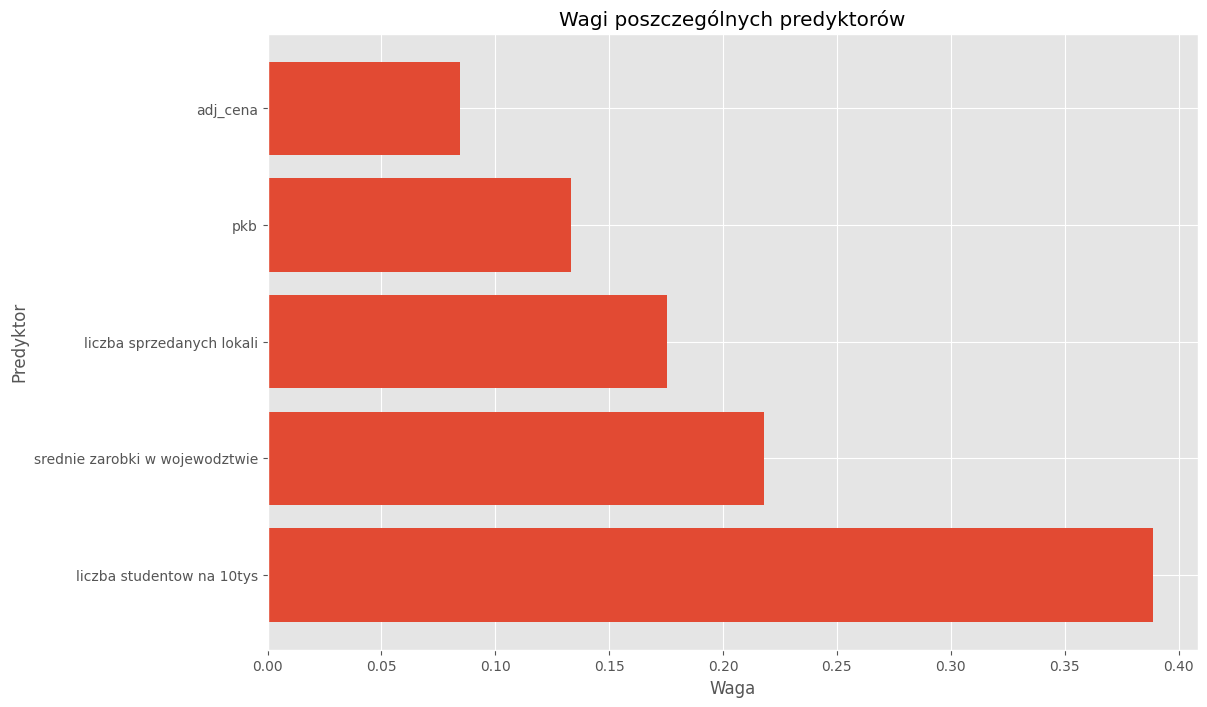

In [18]:
import xgboost as xgb

rf = xgb.XGBClassifier()
rf.fit(price_data[predictors], price_data[target])

importances = rf.feature_importances_
feature_names = [ 'pkb', 'liczba studentow na 10tys','liczba sprzedanych lokali',
       'srednie zarobki w wojewodztwie', 'adj_cena']
importance_scores = dict(zip(feature_names, importances))
sorted_importances = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

features = [feature for feature, _ in sorted_importances]
importance_values = [importance for _, importance in sorted_importances]

# Plot the feature importances
plt.barh(features, importance_values)
plt.xlabel('Waga')
plt.ylabel('Predyktor')
plt.title('Wagi poszczególnych predyktorów')
plt.show()

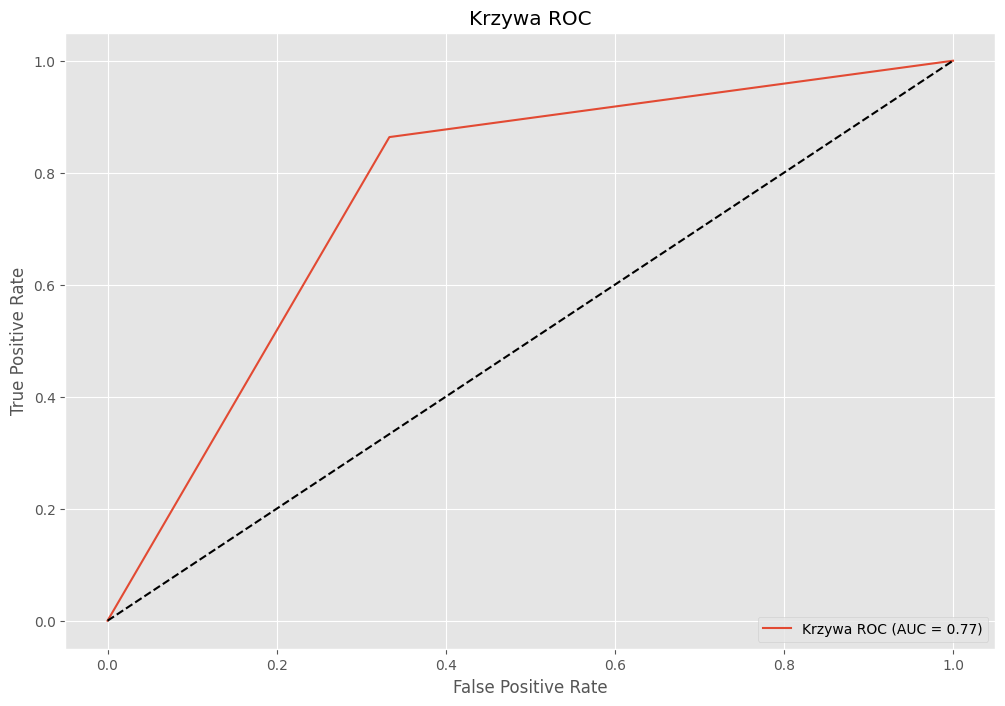

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
accuracy_score(price_data.iloc[START:][target], preds)
# Obliczamy FPR, TPR i progi
fpr, tpr, thresholds = roc_curve(y_true, preds)

# Obliczamy obszar pod krzywą ROC (AUC)
auc = roc_auc_score(y_true, preds)

# Wyświetlamy krzywą ROC
plt.plot(fpr, tpr, label='Krzywa ROC (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Linia losowej klasyfikacji
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC')
plt.legend(loc='lower right')
plt.show()

In [20]:
from sklearn.metrics import f1_score



# Calculate F1-score
f1 = f1_score(y_true, preds)

print("F1-score:", f1)

F1-score: 0.9047619047619048


In [21]:
from sklearn.metrics import recall_score

# Calculate recall score
recall = recall_score(y_true, preds)

print("Recall:", recall)

Recall: 0.8636363636363636
